# Getting some baseline

So, I've been tuning now this model for too long. Probably it is good to just get some simple baselines and compare it to them to see how good we are in the end. 

In [5]:
%load_ext autoreload
%autoreload 2
import joblib
import pandas as pd
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler
from colorml.utils.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.utils.descriptornames import *

CHEMICAL_FEATURES = [
    'mc_CRY-chi-0-all',
    'mc_CRY-chi-1-all',
    'mc_CRY-chi-2-all',
    'mc_CRY-chi-3-all',
    'mc_CRY-Z-0-all',
    'mc_CRY-Z-1-all',
    'mc_CRY-Z-2-all',
    'mc_CRY-Z-3-all',
    'mc_CRY-I-1-all',
    'mc_CRY-I-2-all',
    'mc_CRY-I-3-all',
    'mc_CRY-T-0-all',
    'mc_CRY-T-1-all',
    'mc_CRY-T-2-all',
    'mc_CRY-T-3-all',
    'mc_CRY-S-0-all',
    'mc_CRY-S-1-all',
    'mc_CRY-S-2-all',
    'mc_CRY-S-3-all',
    'D_mc_CRY-chi-1-all',
    'D_mc_CRY-chi-2-all',
    'D_mc_CRY-chi-3-all',
    'D_mc_CRY-Z-1-all',
    'D_mc_CRY-Z-2-all',
    'D_mc_CRY-Z-3-all',
    'D_mc_CRY-T-1-all',
    'D_mc_CRY-T-2-all',
    'D_mc_CRY-T-3-all',
    'D_mc_CRY-S-1-all',
    'D_mc_CRY-S-2-all',
    'D_mc_CRY-S-3-all',
    'func-chi-0-all',
    'func-chi-1-all',
    'func-chi-2-all',
    'func-chi-3-all',
    'func-Z-0-all',
    'func-Z-1-all',
    'func-Z-2-all',
    'func-Z-3-all',
    'func-I-1-all',
    'func-I-2-all',
    'func-I-3-all',
    'func-T-0-all',
    'func-T-1-all',
    'func-T-2-all',
    'func-T-3-all',
    'func-S-0-all',
    'func-S-1-all',
    'func-S-2-all',
    'func-S-3-all',
    'func-alpha-0-all',
    'func-alpha-1-all',
    'func-alpha-2-all',
    'func-alpha-3-all',
    'D_func-chi-1-all',
    'D_func-chi-2-all',
    'D_func-chi-3-all',
    'D_func-Z-1-all',
    'D_func-Z-2-all',
    'D_func-Z-3-all',
    'D_func-T-1-all',
    'D_func-T-2-all',
    'D_func-T-3-all',
    'D_func-S-2-all',
    'D_func-S-3-all',
    'D_func-alpha-1-all',
    'D_func-alpha-2-all',
    'D_func-alpha-3-all',
    'f-lig-chi-0',
    'f-lig-chi-1',
    'f-lig-chi-2',
    'f-lig-chi-3',
    'f-lig-Z-0',
    'f-lig-Z-1',
    'f-lig-Z-2',
    'f-lig-Z-3',
    'f-lig-I-0',
    'f-lig-I-1',
    'f-lig-I-2',
    'f-lig-I-3',
    'f-lig-T-0',
    'f-lig-T-1',
    'f-lig-T-2',
    'f-lig-T-3',
    'f-lig-S-0',
    'f-lig-S-1',
    'f-lig-S-2',
    'f-lig-S-3',
    'lc-chi-0-all',
    'lc-chi-1-all',
    'lc-chi-2-all',
    'lc-chi-3-all',
    'lc-Z-0-all',
    'lc-Z-1-all',
    'lc-Z-2-all',
    'lc-Z-3-all',
    'lc-I-2-all',
    'lc-I-3-all',
    'lc-T-0-all',
    'lc-T-1-all',
    'lc-T-2-all',
    'lc-T-3-all',
    'lc-S-3-all',
    'lc-alpha-0-all',
    'lc-alpha-1-all',
    'lc-alpha-2-all',
    'lc-alpha-3-all',
    'D_lc-chi-2-all',
    'D_lc-chi-3-all',
    'D_lc-Z-1-all',
    'D_lc-Z-2-all',
    'D_lc-Z-3-all',
    'D_lc-T-1-all',
    'D_lc-T-2-all',
    'D_lc-T-3-all',
    'D_lc-alpha-1-all',
    'D_lc-alpha-2-all',
    'D_lc-alpha-3-all',
    'tertiary_amide_sum',
    'ester_sum',
    'carbonyl_sum',
    'logP_sum',
    'MR_sum',
    'aromatic_rings_sum',
    'dbonds_sum',
    'abonds_sum',
    'tertiary_amide_mean',
    'ester_mean',
    'carbonyl_mean',
    'logP_mean',
    'MR_mean',
    'aromatic_rings_mean',
    'dbonds_mean',
    'abonds_mean',
    'sum-func-chi-0-all',
    'sum-func-chi-1-all',
    'sum-func-chi-2-all',
    'sum-func-chi-3-all',
    'sum-func-Z-0-all',
    'sum-func-Z-1-all',
    'sum-func-Z-2-all',
    'sum-func-Z-3-all',
    'sum-func-I-0-all',
    'sum-func-I-1-all',
    'sum-func-I-2-all',
    'sum-func-I-3-all',
    'sum-func-T-0-all',
    'sum-func-T-1-all',
    'sum-func-T-2-all',
    'sum-func-T-3-all',
    'sum-func-S-0-all',
    'sum-func-S-1-all',
    'sum-func-S-2-all',
    'sum-func-S-3-all',
    'sum-func-alpha-0-all',
    'sum-func-alpha-1-all',
    'sum-func-alpha-2-all',
    'sum-func-alpha-3-all',
    'sum-D_func-chi-1-all',
    'sum-D_func-chi-2-all',
    'sum-D_func-chi-3-all',
    'sum-D_func-Z-1-all',
    'sum-D_func-Z-2-all',
    'sum-D_func-Z-3-all',
    'sum-D_func-T-1-all',
    'sum-D_func-T-2-all',
    'sum-D_func-T-3-all',
    'sum-D_func-S-1-all',
    'sum-D_func-S-2-all',
    'sum-D_func-S-3-all',
    'sum-D_func-alpha-1-all',
    'sum-D_func-alpha-2-all',
    'sum-D_func-alpha-3-all',
    'sum-f-lig-chi-0',
    'sum-f-lig-chi-1',
    'sum-f-lig-chi-2',
    'sum-f-lig-chi-3',
    'sum-f-lig-Z-0',
    'sum-f-lig-Z-1',
    'sum-f-lig-Z-2',
    'sum-f-lig-Z-3',
    'sum-f-lig-I-0',
    'sum-f-lig-I-1',
    'sum-f-lig-I-2',
    'sum-f-lig-I-3',
    'sum-f-lig-T-0',
    'sum-f-lig-T-1',
    'sum-f-lig-T-2',
    'sum-f-lig-T-3',
    'sum-f-lig-S-0',
    'sum-f-lig-S-1',
    'sum-f-lig-S-2',
    'sum-f-lig-S-3',
    'sum-lc-chi-0-all',
    'sum-lc-chi-1-all',
    'sum-lc-chi-2-all',
    'sum-lc-chi-3-all',
    'sum-lc-Z-0-all',
    'sum-lc-Z-1-all',
    'sum-lc-Z-2-all',
    'sum-lc-Z-3-all',
    'sum-lc-I-0-all',
    'sum-lc-I-1-all',
    'sum-lc-I-2-all',
    'sum-lc-I-3-all',
    'sum-lc-T-0-all',
    'sum-lc-T-1-all',
    'sum-lc-T-2-all',
    'sum-lc-T-3-all',
    'sum-lc-S-0-all',
    'sum-lc-S-1-all',
    'sum-lc-S-2-all',
    'sum-lc-S-3-all',
    'sum-lc-alpha-0-all',
    'sum-lc-alpha-1-all',
    'sum-lc-alpha-2-all',
    'sum-lc-alpha-3-all',
    'sum-D_lc-chi-1-all',
    'sum-D_lc-chi-2-all',
    'sum-D_lc-chi-3-all',
    'sum-D_lc-Z-1-all',
    'sum-D_lc-Z-2-all',
    'sum-D_lc-Z-3-all',
    'sum-D_lc-T-1-all',
    'sum-D_lc-T-2-all',
    'sum-D_lc-T-3-all',
    'sum-D_lc-S-1-all',
    'sum-D_lc-S-2-all',
    'sum-D_lc-S-3-all',
    'sum-D_lc-alpha-1-all',
    'sum-D_lc-alpha-2-all',
    'sum-D_lc-alpha-3-all',
    'sum-mc_CRY-chi-0-all',
    'sum-mc_CRY-chi-1-all',
    'sum-mc_CRY-chi-2-all',
    'sum-mc_CRY-chi-3-all',
    'sum-mc_CRY-Z-0-all',
    'sum-mc_CRY-Z-1-all',
    'sum-mc_CRY-Z-2-all',
    'sum-mc_CRY-Z-3-all',
    'sum-mc_CRY-I-0-all',
    'sum-mc_CRY-I-1-all',
    'sum-mc_CRY-I-2-all',
    'sum-mc_CRY-I-3-all',
    'sum-mc_CRY-T-0-all',
    'sum-mc_CRY-T-1-all',
    'sum-mc_CRY-T-2-all',
    'sum-mc_CRY-T-3-all',
    'sum-mc_CRY-S-0-all',
    'sum-mc_CRY-S-1-all',
    'sum-mc_CRY-S-2-all',
    'sum-mc_CRY-S-3-all',
    'sum-D_mc_CRY-chi-1-all',
    'sum-D_mc_CRY-chi-2-all',
    'sum-D_mc_CRY-chi-3-all',
    'sum-D_mc_CRY-Z-1-all',
    'sum-D_mc_CRY-Z-2-all',
    'sum-D_mc_CRY-Z-3-all',
    'sum-D_mc_CRY-T-1-all',
    'sum-D_mc_CRY-T-2-all',
    'sum-D_mc_CRY-T-3-all',
    'sum-D_mc_CRY-S-1-all',
    'sum-D_mc_CRY-S-2-all',
    'sum-D_mc_CRY-S-3-all',
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from sklearn.dummy import DummyRegressor

In [7]:
df_train = pd.read_csv('../data/development_set.csv')
df_test = pd.read_csv('../data/holdout_set.csv')

In [8]:
X_train = df_train[CHEMICAL_FEATURES]
X_test = df_test[CHEMICAL_FEATURES]

In [11]:
y_train = df_train[['r', 'g', 'b']].values / 255
y_test = df_test[['r', 'g', 'b']].values / 255

In [12]:
name_train = df_train['color_cleaned']
name_test = df_test['color_cleaned']

In [13]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_median = DummyRegressor(strategy='median')

In [14]:
dummy_mean.fit(X_train, y_train)
dummy_median.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [15]:
joblib.dump(dummy_mean, '../results/dummy_mean.joblib')

['../results/dummy_mean.joblib']

In [16]:
joblib.dump(dummy_median, '../results/dummy_median.joblib')

['../results/dummy_median.joblib']

In [19]:
mean_prediction_test = dummy_mean.predict(X_test)
median_predicton_test = dummy_median.predict(X_test)

/Users/kevinmaikjablonka/Dropbox (LSMO)/proj75_mofcolor/ml/colorml/utils/utils.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


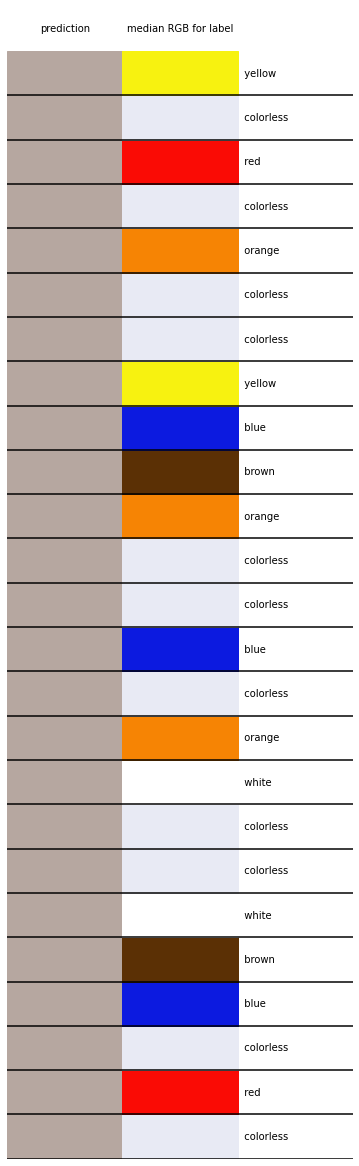

In [20]:
plot_predictions(mean_prediction_test * 255, 
                 y_test * 255,  name_test.values, 
                 sample=25, outname='mean_baseline.pdf')

/Users/kevinmaikjablonka/Dropbox (LSMO)/proj75_mofcolor/ml/colorml/utils/utils.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


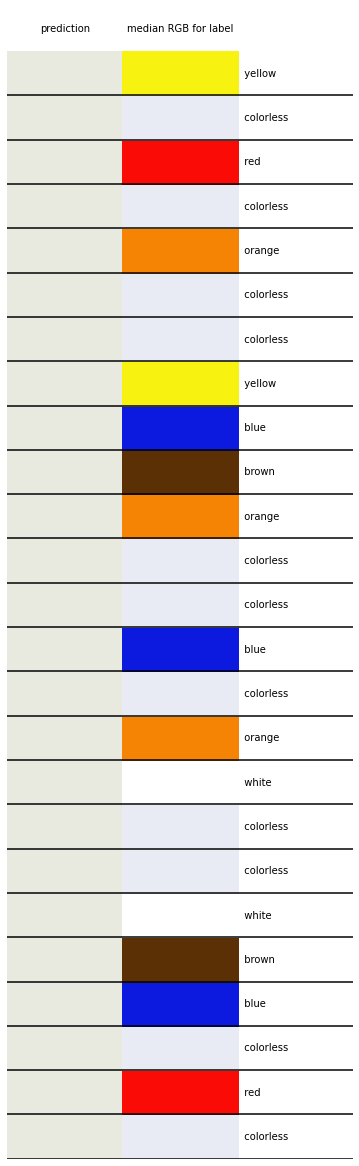

In [21]:
plot_predictions(median_predicton_test * 255, 
                 y_test * 255,  name_test.values, 
                 sample=25, outname='median_baseline.pdf')

In [36]:
from sklearn.neighbors import KNeighborsRegressor

In [37]:
knn1 = KNeighborsRegressor(1)
knn4 = KNeighborsRegressor(4)

In [38]:
knn1.fit(X_train, y_train)
knn4.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [39]:
knn1_prediction = knn1.predict(X_test)

In [40]:
knn4_prediction = knn4.predict(X_test)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


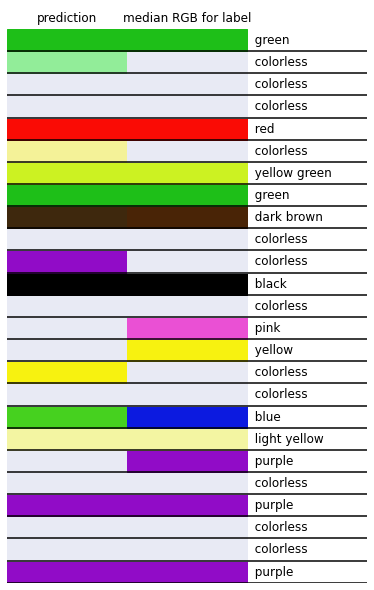

In [41]:
plot_predictions(yscaler.inverse_transform(knn1_prediction), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='knn1_baseline.pdf')

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


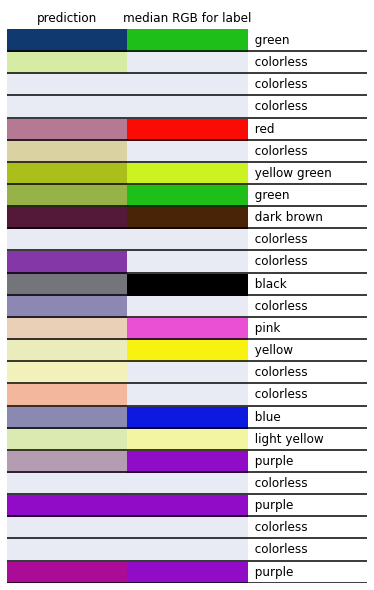

In [42]:
plot_predictions(yscaler.inverse_transform(knn4_prediction), 
                 yscaler.inverse_transform(y_test),  name_test.values, 
                 sample=25, outname='knn4_baseline.pdf')

In [43]:
get_metrics(y_test, knn1_prediction)

{'r2': 0.0385442949292207,
 'mae': 0.5249477657935612,
 'mse': 1.0015340363866634}

In [44]:
get_metrics(y_test, knn4_prediction)

{'r2': 0.24475977464798404,
 'mae': 0.6183640394547121,
 'mse': 0.7861595007965327}